Data from: https://www.kaggle.com/code/paultimothymooney/predict-diabetes-from-medical-records/input

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.<br>The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.<br>Several constraints were placed on the selection of these instances from a larger database.<br>In particular, **all patients here are females at least 21 years old of Pima Indian heritage** (https://www.britannica.com/topic/Pima-people).

The datasets consists of only eight physiological and demographic predictor variables and one target variable, Outcome.<br>

`Pregnancies` The number of pregnancies the subject has had.<br><br>
`Glucose` Blood glucose level 2 hours after an oral glucose tolerance test (mg/dL).<br><br>
`BloodPressure` The diastolic/resting blood pressure (mmHg).<br><br>
`SkinThickness` Tricep skin fold thickness (mm).<br><br>
`Insulin` Serum insulin level 2 hours after administering glucose tolerance test (uU/mL).<br><br>
`BMI` Body Mass Index calculated as the weight (kg) divided by the square of the height (m).<br><br>
`DiabetesPedigreeFunction` A score derived from genetic and familial diabetes history.<br><br>
`Age` The age, in years, of the females ranging from 21.<br><br>
`Outcome` Class/target variable (0 absence of diabetes or 1 presence of diabetes).


In [1]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import subplots, show
from numpy import nan, clip, where, round, mean, arange
from seaborn import heatmap, pairplot, boxplot

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
# from keras.metrics import binary_crossentropy


# Load & inspect datatset

In [2]:
diabetes_df = read_csv('diabetes.csv')
print(diabetes_df.shape)
print(diabetes_df.columns)
diabetes_df.head()

(768, 9)
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Apparently there are no null entries.

In [7]:
diabetes_df.duplicated().sum()

np.int64(0)

No row duplication.

In [8]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Several features have min=0.0 ('Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI').<br>
Clearly they cannot be valid and is suggestive of missing values defaulting to 0.0.

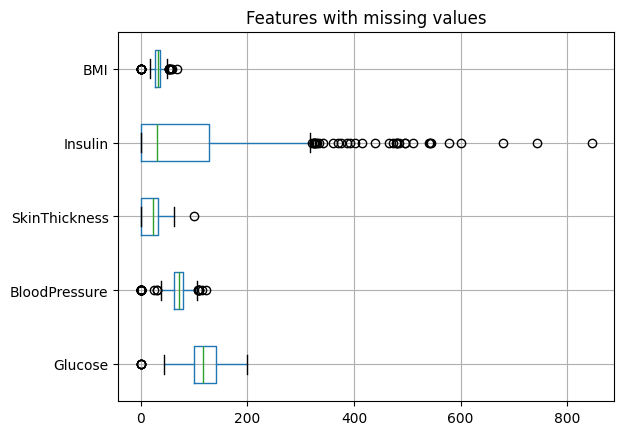

In [ ]:
# Boxplot inspection of these anomolous features

fig, ax =subplots()

diabetes_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].boxplot(vert=False)
ax.set_title('Features with missing values')

show()

The boxplot confirms the presence of 0s.

In [10]:
# Inspect missing values (0s)

feats_missing_vals = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Missing values/0s counts:")
for col in feats_missing_vals:
    num_zeros = (diabetes_df[col] == 0).sum()  # Count all the 0 values
    pc_zeros = round(num_zeros/len(diabetes_df)*100, 1)
    print(f"{col}: {num_zeros} ({pc_zeros}%)")

Missing values/0s counts:
Glucose: 5 (0.7%)
BloodPressure: 35 (4.6%)
SkinThickness: 227 (29.6%)
Insulin: 374 (48.7%)
BMI: 11 (1.4%)


The presence of 0s skews the means and medians of each feature (especially `SkinThickness` and `Insulin`!).<br>
Therefore, need to convert 0s to NaN to get better idea of features' means, medians and distributions.

# Replace 0s with NaN

In [11]:
# Convert 0s to NaN to unskew data

diabetes_df['Glucose'] = diabetes_df['Glucose'].replace(0, nan)
diabetes_df['BloodPressure'] = diabetes_df['BloodPressure'].replace(0, nan)
diabetes_df['SkinThickness'] = diabetes_df['SkinThickness'].replace(0, nan)
diabetes_df['Insulin'] = diabetes_df['Insulin'].replace(0, nan)
diabetes_df['BMI'] = diabetes_df['BMI'].replace(0, nan)


In [12]:
# Inspect missing values after 0-->NaN replacement

diabetes_df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

The numbers of missing values match the numbers of 0s found above.

In [13]:
# Inspect basic statistics after 0-->NaN replacement

diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


For features which had 0s/missing values, the means generally increase, as expected.

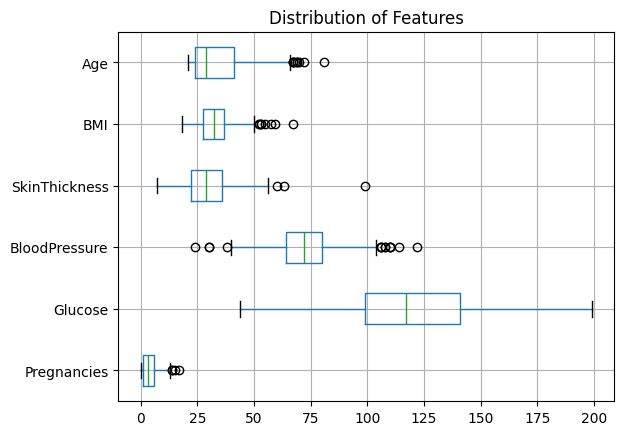

In [14]:
# Inspect boxplot distribution of features after 0-->NaN replacement
# Toggle comment to view the three boxplots

fig, ax =subplots()

diabetes_df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age']].boxplot(vert=False)
# diabetes_df[['DiabetesPedigreeFunction']].boxplot(vert=False)
# diabetes_df[['Insulin']].boxplot(vert=False)
ax.set_title('Distribution of Features')

show()

# Clip 'Insulin' and 'SkinThickness'

In [15]:
# Check outliers for Insulin and SkinThickness

print(diabetes_df['Insulin'].sort_values().head())
print(diabetes_df['Insulin'].sort_values(ascending=False).head())
print()
print(diabetes_df['SkinThickness'].sort_values().head())
print(diabetes_df['SkinThickness'].sort_values(ascending=False).head())


445    14.0
617    15.0
760    16.0
566    18.0
108    18.0
Name: Insulin, dtype: float64
13     846.0
228    744.0
247    680.0
584    600.0
409    579.0
Name: Insulin, dtype: float64

254     7.0
519     7.0
434     8.0
382     8.0
279    10.0
Name: SkinThickness, dtype: float64
579    99.0
445    63.0
57     60.0
120    56.0
211    54.0
Name: SkinThickness, dtype: float64


In [16]:
# Clip Insulin max to 600 and SkinThickness to 65

diabetes_df['Insulin'] = clip(diabetes_df['Insulin'], diabetes_df['Insulin'].min(), 600)

diabetes_df['SkinThickness'] = clip(diabetes_df['SkinThickness'], diabetes_df['SkinThickness'].min(), 65)

# Check outcome of clipping
print(diabetes_df['Insulin'].sort_values().head())
print(diabetes_df['Insulin'].sort_values(ascending=False).head())
print()
print(diabetes_df['SkinThickness'].sort_values().head())
print(diabetes_df['SkinThickness'].sort_values(ascending=False).head())

445    14.0
617    15.0
760    16.0
566    18.0
108    18.0
Name: Insulin, dtype: float64
584    600.0
247    600.0
228    600.0
13     600.0
409    579.0
Name: Insulin, dtype: float64

254     7.0
519     7.0
434     8.0
382     8.0
279    10.0
Name: SkinThickness, dtype: float64
579    65.0
445    63.0
57     60.0
120    56.0
211    54.0
Name: SkinThickness, dtype: float64


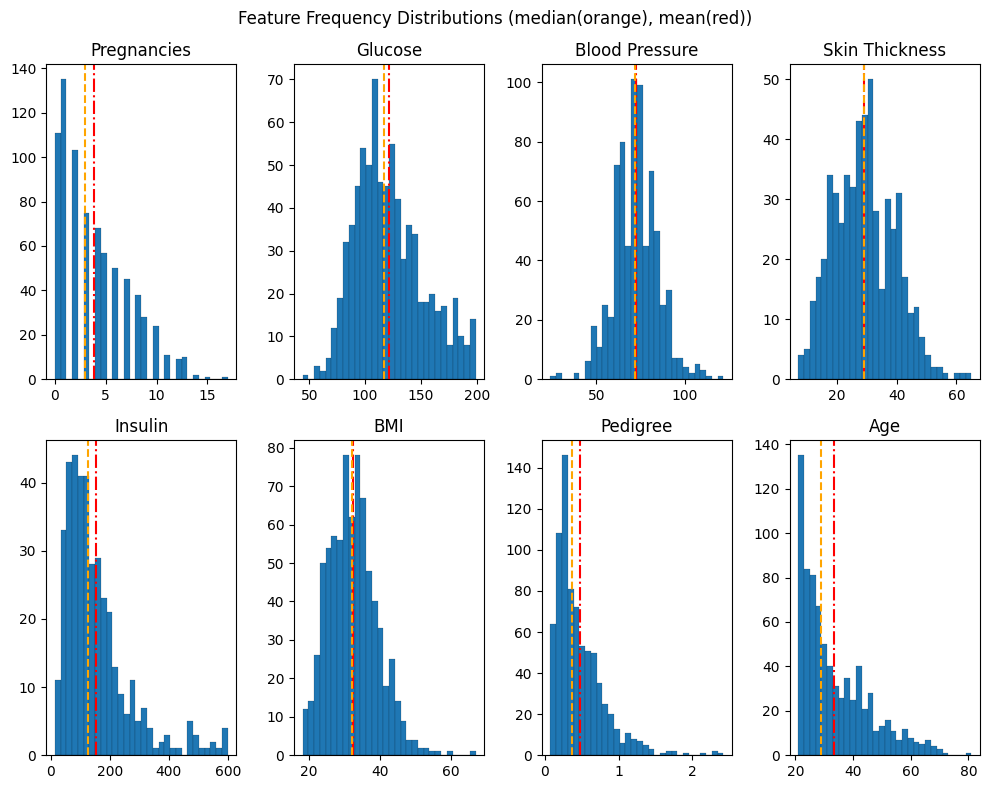

In [17]:
# Frequency distribution of features

n_rows = 2
n_cols = 4
n_bins = 30
line_width = 0.1
edge_colour = 'k'

fig, ax  = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,8))

ax[0,0].hist(diabetes_df['Pregnancies'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,0].axvline(diabetes_df['Pregnancies'].mean(), linestyle='-.', c='r')
ax[0,0].axvline(diabetes_df['Pregnancies'].median(), linestyle='--', c='orange')
ax[0,0].set_title('Pregnancies')

ax[0,1].hist(diabetes_df['Glucose'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,1].axvline(diabetes_df['Glucose'].mean(), linestyle='-.', c='r')
ax[0,1].axvline(diabetes_df['Glucose'].median(), linestyle='--', c='orange')
ax[0,1].set_title('Glucose')

ax[0,2].hist(diabetes_df['BloodPressure'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,2].axvline(diabetes_df['BloodPressure'].mean(), linestyle='-.', c='r')
ax[0,2].axvline(diabetes_df['BloodPressure'].median(), linestyle='--', c='orange')
ax[0,2].set_title('Blood Pressure')

ax[0,3].hist(diabetes_df['SkinThickness'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,3].axvline(diabetes_df['SkinThickness'].mean(), linestyle='-.', c='r')
ax[0,3].axvline(diabetes_df['SkinThickness'].median(), linestyle='--', c='orange')
ax[0,3].set_title('Skin Thickness')

ax[1,0].hist(diabetes_df['Insulin'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[1,0].axvline(diabetes_df['Insulin'].mean(), linestyle='-.', c='r')
ax[1,0].axvline(diabetes_df['Insulin'].median(), linestyle='--', c='orange')
ax[1,0].set_title('Insulin')

ax[1,1].hist(diabetes_df['BMI'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[1,1].axvline(diabetes_df['BMI'].mean(), linestyle='-.', c='r')
ax[1,1].axvline(diabetes_df['BMI'].median(), linestyle='--', c='orange')
ax[1,1].set_title('BMI')

ax[1,2].hist(diabetes_df['DiabetesPedigreeFunction'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[1,2].axvline(diabetes_df['DiabetesPedigreeFunction'].mean(), linestyle='-.', c='r')
ax[1,2].axvline(diabetes_df['DiabetesPedigreeFunction'].median(), linestyle='--', c='orange')
ax[1,2].set_title('Pedigree')

ax[1,3].hist(diabetes_df['Age'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[1,3].axvline(diabetes_df['Age'].mean(), linestyle='-.', c='r')
ax[1,3].axvline(diabetes_df['Age'].median(), linestyle='--', c='orange')
ax[1,3].set_title('Age')

fig.suptitle('Feature Frequency Distributions (median(orange), mean(red))')
fig.tight_layout()
show()

Pregnancies, Insulin, Pedigree and Age are skewed, but other features are normal-ish distributed.

# Imputation
Impute Insulin missing values with median.<br>
Impute missing values of normal-ish distributed features (Glucose, BloodPressure, SkinThickness, BMI) with mean.

In [18]:
diabetes_df['Insulin'] = diabetes_df['Insulin'].fillna(diabetes_df['Insulin'].median())

diabetes_df['Glucose'] = diabetes_df['Glucose'].fillna(diabetes_df['Glucose'].mean())
diabetes_df['BloodPressure'] = diabetes_df['BloodPressure'].fillna(diabetes_df['BloodPressure'].mean())
diabetes_df['SkinThickness'] = diabetes_df['SkinThickness'].fillna(diabetes_df['SkinThickness'].mean())
diabetes_df['BMI'] = diabetes_df['BMI'].fillna(diabetes_df['BMI'].mean())

In [19]:
# Check outcome of imputation

print(diabetes_df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [20]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.090573,140.059896,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.520132,82.367758,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.090573,125.000000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,65.000000,600.000000,67.100000,2.420000,81.000000,1.000000


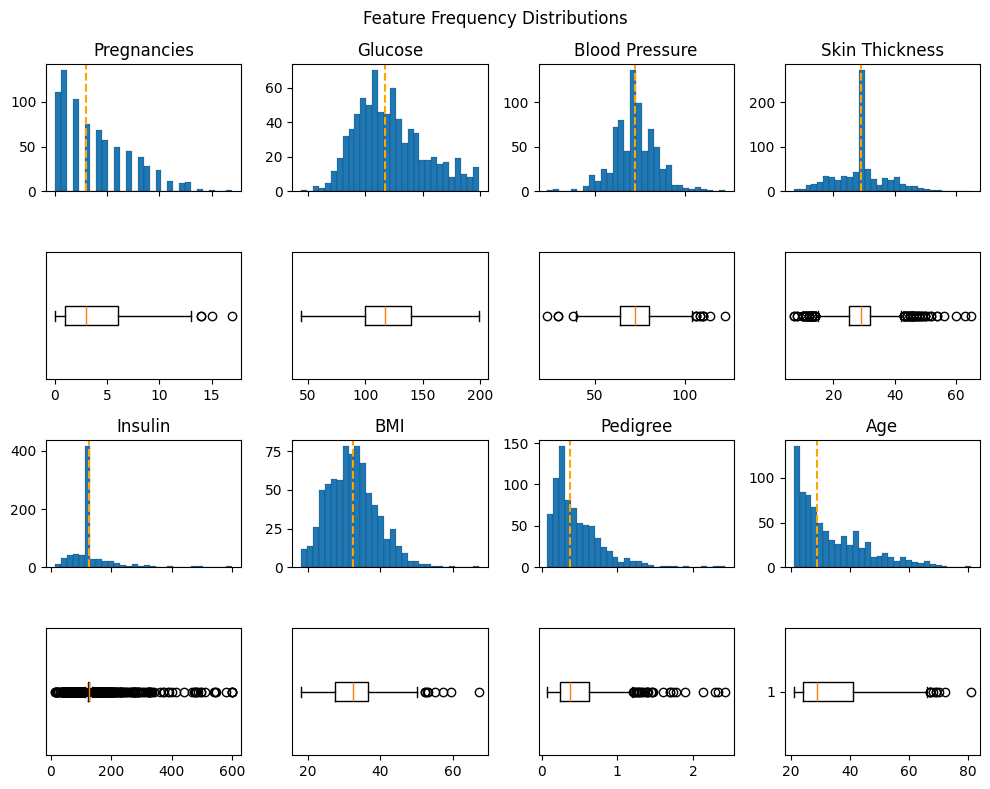

In [21]:
# Frequency distribution of features (histograms & boxplots)

n_rows = 4
n_cols = 4
n_bins = 30
line_width = 0.1
edge_colour = 'k'

fig, ax  = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,8))

ax[0,0].hist(diabetes_df['Pregnancies'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,0].set_xticklabels([])
ax[0,0].axvline(diabetes_df['Pregnancies'].median(), linestyle='--', c='orange')
ax[0,0].set_title('Pregnancies')
ax[1,0].boxplot(diabetes_df['Pregnancies'], vert=False)
ax[1,0].set_yticks([])

ax[0,1].hist(diabetes_df['Glucose'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,1].set_xticklabels([])
ax[0,1].axvline(diabetes_df['Glucose'].median(), linestyle='--', c='orange')
ax[0,1].set_title('Glucose')
ax[1,1].boxplot(diabetes_df['Glucose'], vert=False)
ax[1,1].set_yticks([])

ax[0,2].hist(diabetes_df['BloodPressure'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,2].set_xticklabels([])
ax[0,2].axvline(diabetes_df['BloodPressure'].median(), linestyle='--', c='orange')
ax[0,2].set_title('Blood Pressure')
ax[1,2].boxplot(diabetes_df['BloodPressure'], vert=False)
ax[1,2].set_yticks([])

ax[0,3].hist(diabetes_df['SkinThickness'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,3].set_xticklabels([])
ax[0,3].axvline(diabetes_df['SkinThickness'].median(), linestyle='--', c='orange')
ax[0,3].set_title('Skin Thickness')
ax[1,3].boxplot(diabetes_df['SkinThickness'], vert=False)
ax[1,3].set_yticks([])

ax[2,0].hist(diabetes_df['Insulin'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,0].set_xticklabels([])
ax[2,0].axvline(diabetes_df['Insulin'].median(), linestyle='--', c='orange')
ax[2,0].set_title('Insulin')
ax[3,0].boxplot(diabetes_df['Insulin'], vert=False)
ax[3,0].set_yticks([])

ax[2,1].hist(diabetes_df['BMI'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,1].set_xticklabels([])
ax[2,1].axvline(diabetes_df['BMI'].median(), linestyle='--', c='orange')
ax[2,1].set_title('BMI')
ax[3,1].boxplot(diabetes_df['BMI'], vert=False)
ax[3,1].set_yticks([])

ax[2,2].hist(diabetes_df['DiabetesPedigreeFunction'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,2].set_xticklabels([])
ax[2,2].axvline(diabetes_df['DiabetesPedigreeFunction'].median(), linestyle='--', c='orange')
ax[2,2].set_title('Pedigree')
ax[3,2].boxplot(diabetes_df['DiabetesPedigreeFunction'], vert=False)
ax[3,2].set_yticks([])

ax[2,3].hist(diabetes_df['Age'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,3].set_xticklabels([])
ax[2,3].axvline(diabetes_df['Age'].median(), linestyle='--', c='orange')
ax[2,3].set_title('Age')
ax[3,3].boxplot(diabetes_df['Age'], vert=False)
ax[3,0].set_yticks([])

fig.suptitle('Feature Frequency Distributions')
fig.tight_layout()
show()

The imputation of Insulin and SkinThickness, both of which had a high percentage of missing values, 48.7% and 29.6%, respectively, has resulted in an odd distribution for these features.<br>
Overfitting is a concern.<br>
On the other hand, more advanced ML imputing methods such as kNN or MICE (https://medium.com/data-centric-ai-community/ml-imputation-methods-and-why-their-important-8c3a60425745) introduce considerable complexities and are non-trivial to implement.

# Class

Outcome
0    500
1    268
Name: count, dtype: int64


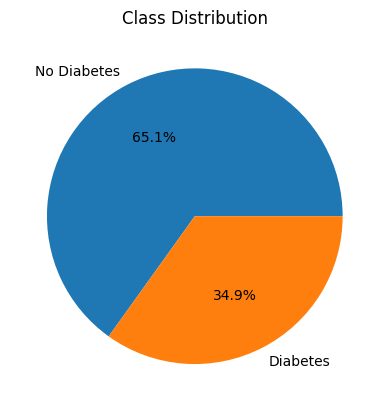

In [22]:
# Inspect class/target distribution

print(diabetes_df['Outcome'].value_counts())

outcome_labels = ['No Diabetes', 'Diabetes']
outcome_counts = diabetes_df['Outcome'].value_counts()

fig, ax = subplots()

ax.pie(outcome_counts, labels=outcome_labels, autopct='%1.1f%%')
ax.set_title('Class Distribution')

show()

2:1 ratio of No Diabetes:Diabetes - I've seen worse.

In [ ]:
# Groupby class

diabetes_df.groupby('Outcome').describe()

Pregnancies                                                Glucose  \
              count      mean       std  min   25%  50%  75%   max   count   
Outcome                                                                      
0             500.0  3.298000  3.017185  0.0  1.00  2.0  5.0  13.0   500.0   
1             268.0  4.865672  3.741239  0.0  1.75  4.0  8.0  17.0   268.0   

                     ... DiabetesPedigreeFunction           Age             \
               mean  ...                      75%    max  count       mean   
Outcome              ...                                                     
0        110.710121  ...                  0.56175  2.329  500.0  31.190000   
1        142.165573  ...                  0.72800  2.420  268.0  37.067164   

                                                  
               std   min   25%   50%   75%   max  
Outcome                                           
0        11.667655  21.0  23.0  27.0  37.0  81.0  
1        10.968254  21.0  28.0  36.0  44.0  70.0  

[2 rows x 64 columns]

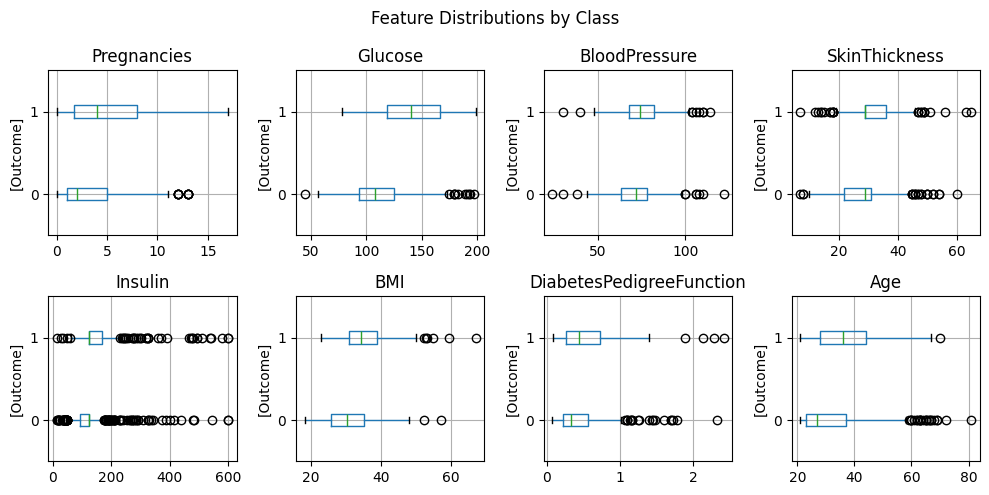

In [24]:
# Boxplots of feature distributions by class

X_df = diabetes_df.drop(columns='Outcome')  # Dataframe of only features, excluding 'Outcome' class

n_rows = 2
n_cols = 4
fig, axes = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,5))

for col, ax in zip(X_df, axes.ravel()):
    diabetes_df[[col, 'Outcome']].boxplot(vert=False, by='Outcome', ax=ax)
    # ax.set_ylabel('')  # Suppress y-label

fig.suptitle('Feature Distributions by Class')
fig.tight_layout()

show()

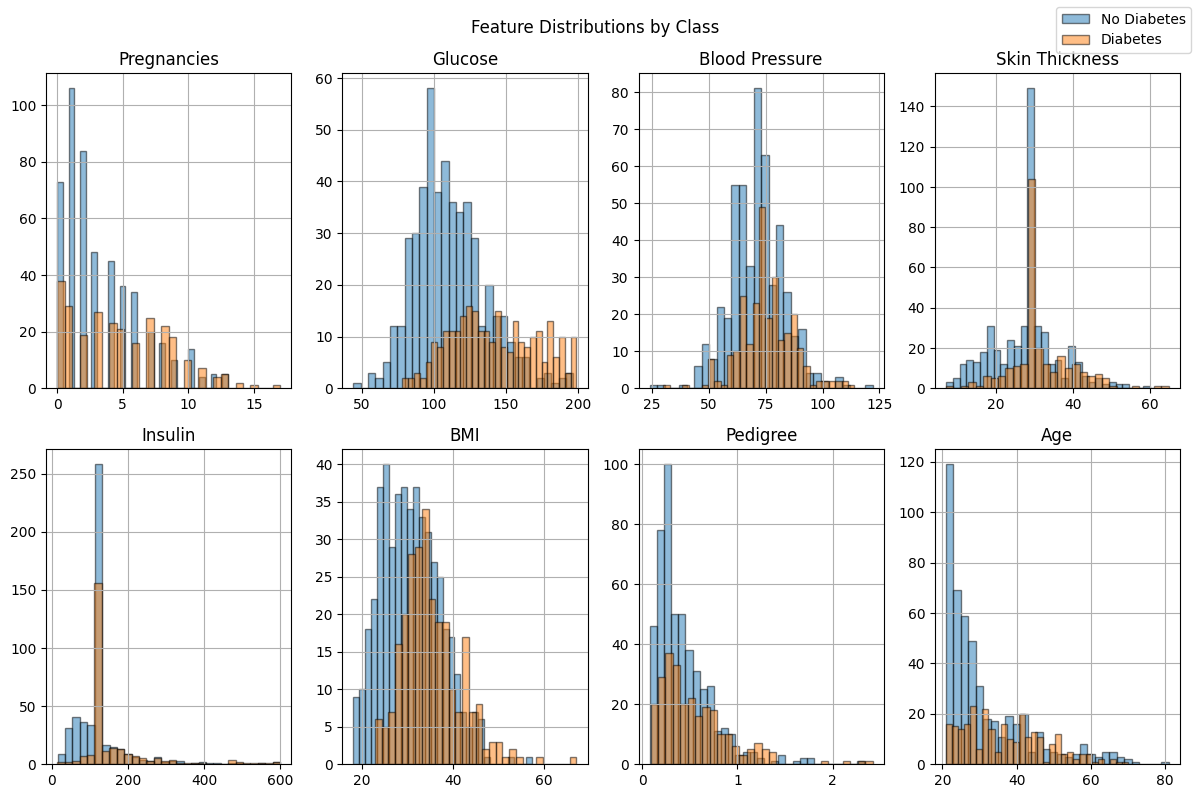

In [25]:
# Histograms of feature distributions by class

n_rows = 2
n_cols = 4
n_bins = 30
alpha = 0.5
line_width = 1
edge_colour = 'k'

fig, ax = subplots(nrows=n_rows, ncols=n_cols, figsize=(12,8))

diabetes_df.groupby('Outcome').Pregnancies.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[0,0])
# ax[0,0].legend(['No Diabetes', 'Diabetes'])
ax[0,0].set_title('Pregnancies')

diabetes_df.groupby('Outcome').Glucose.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[0,1])
ax[0,1].set_title('Glucose')

diabetes_df.groupby('Outcome').BloodPressure.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[0,2])
ax[0,2].set_title('Blood Pressure')

diabetes_df.groupby('Outcome').SkinThickness.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[0,3])
ax[0,3].set_title('Skin Thickness')

diabetes_df.groupby('Outcome').Insulin.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[1,0])
ax[1,0].set_title('Insulin')

diabetes_df.groupby('Outcome').BMI.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[1,1])
ax[1,1].set_title('BMI')

diabetes_df.groupby('Outcome').DiabetesPedigreeFunction.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[1,2])
ax[1,2].set_title('Pedigree')

diabetes_df.groupby('Outcome').Age.hist(bins=n_bins, alpha=alpha, linewidth=line_width, edgecolor=edge_colour, ax=ax[1,3])
ax[1,3].set_title('Age')

fig.suptitle('Feature Distributions by Class')
fig.legend(['No Diabetes', 'Diabetes'])
fig.tight_layout()

show()

Both boxplots and histograms suggest a left-shift for no-diabetes features such as Glucose, SkinThickness, Insulin and BMI. Classification outcome looks promising.

# Correlation analyses

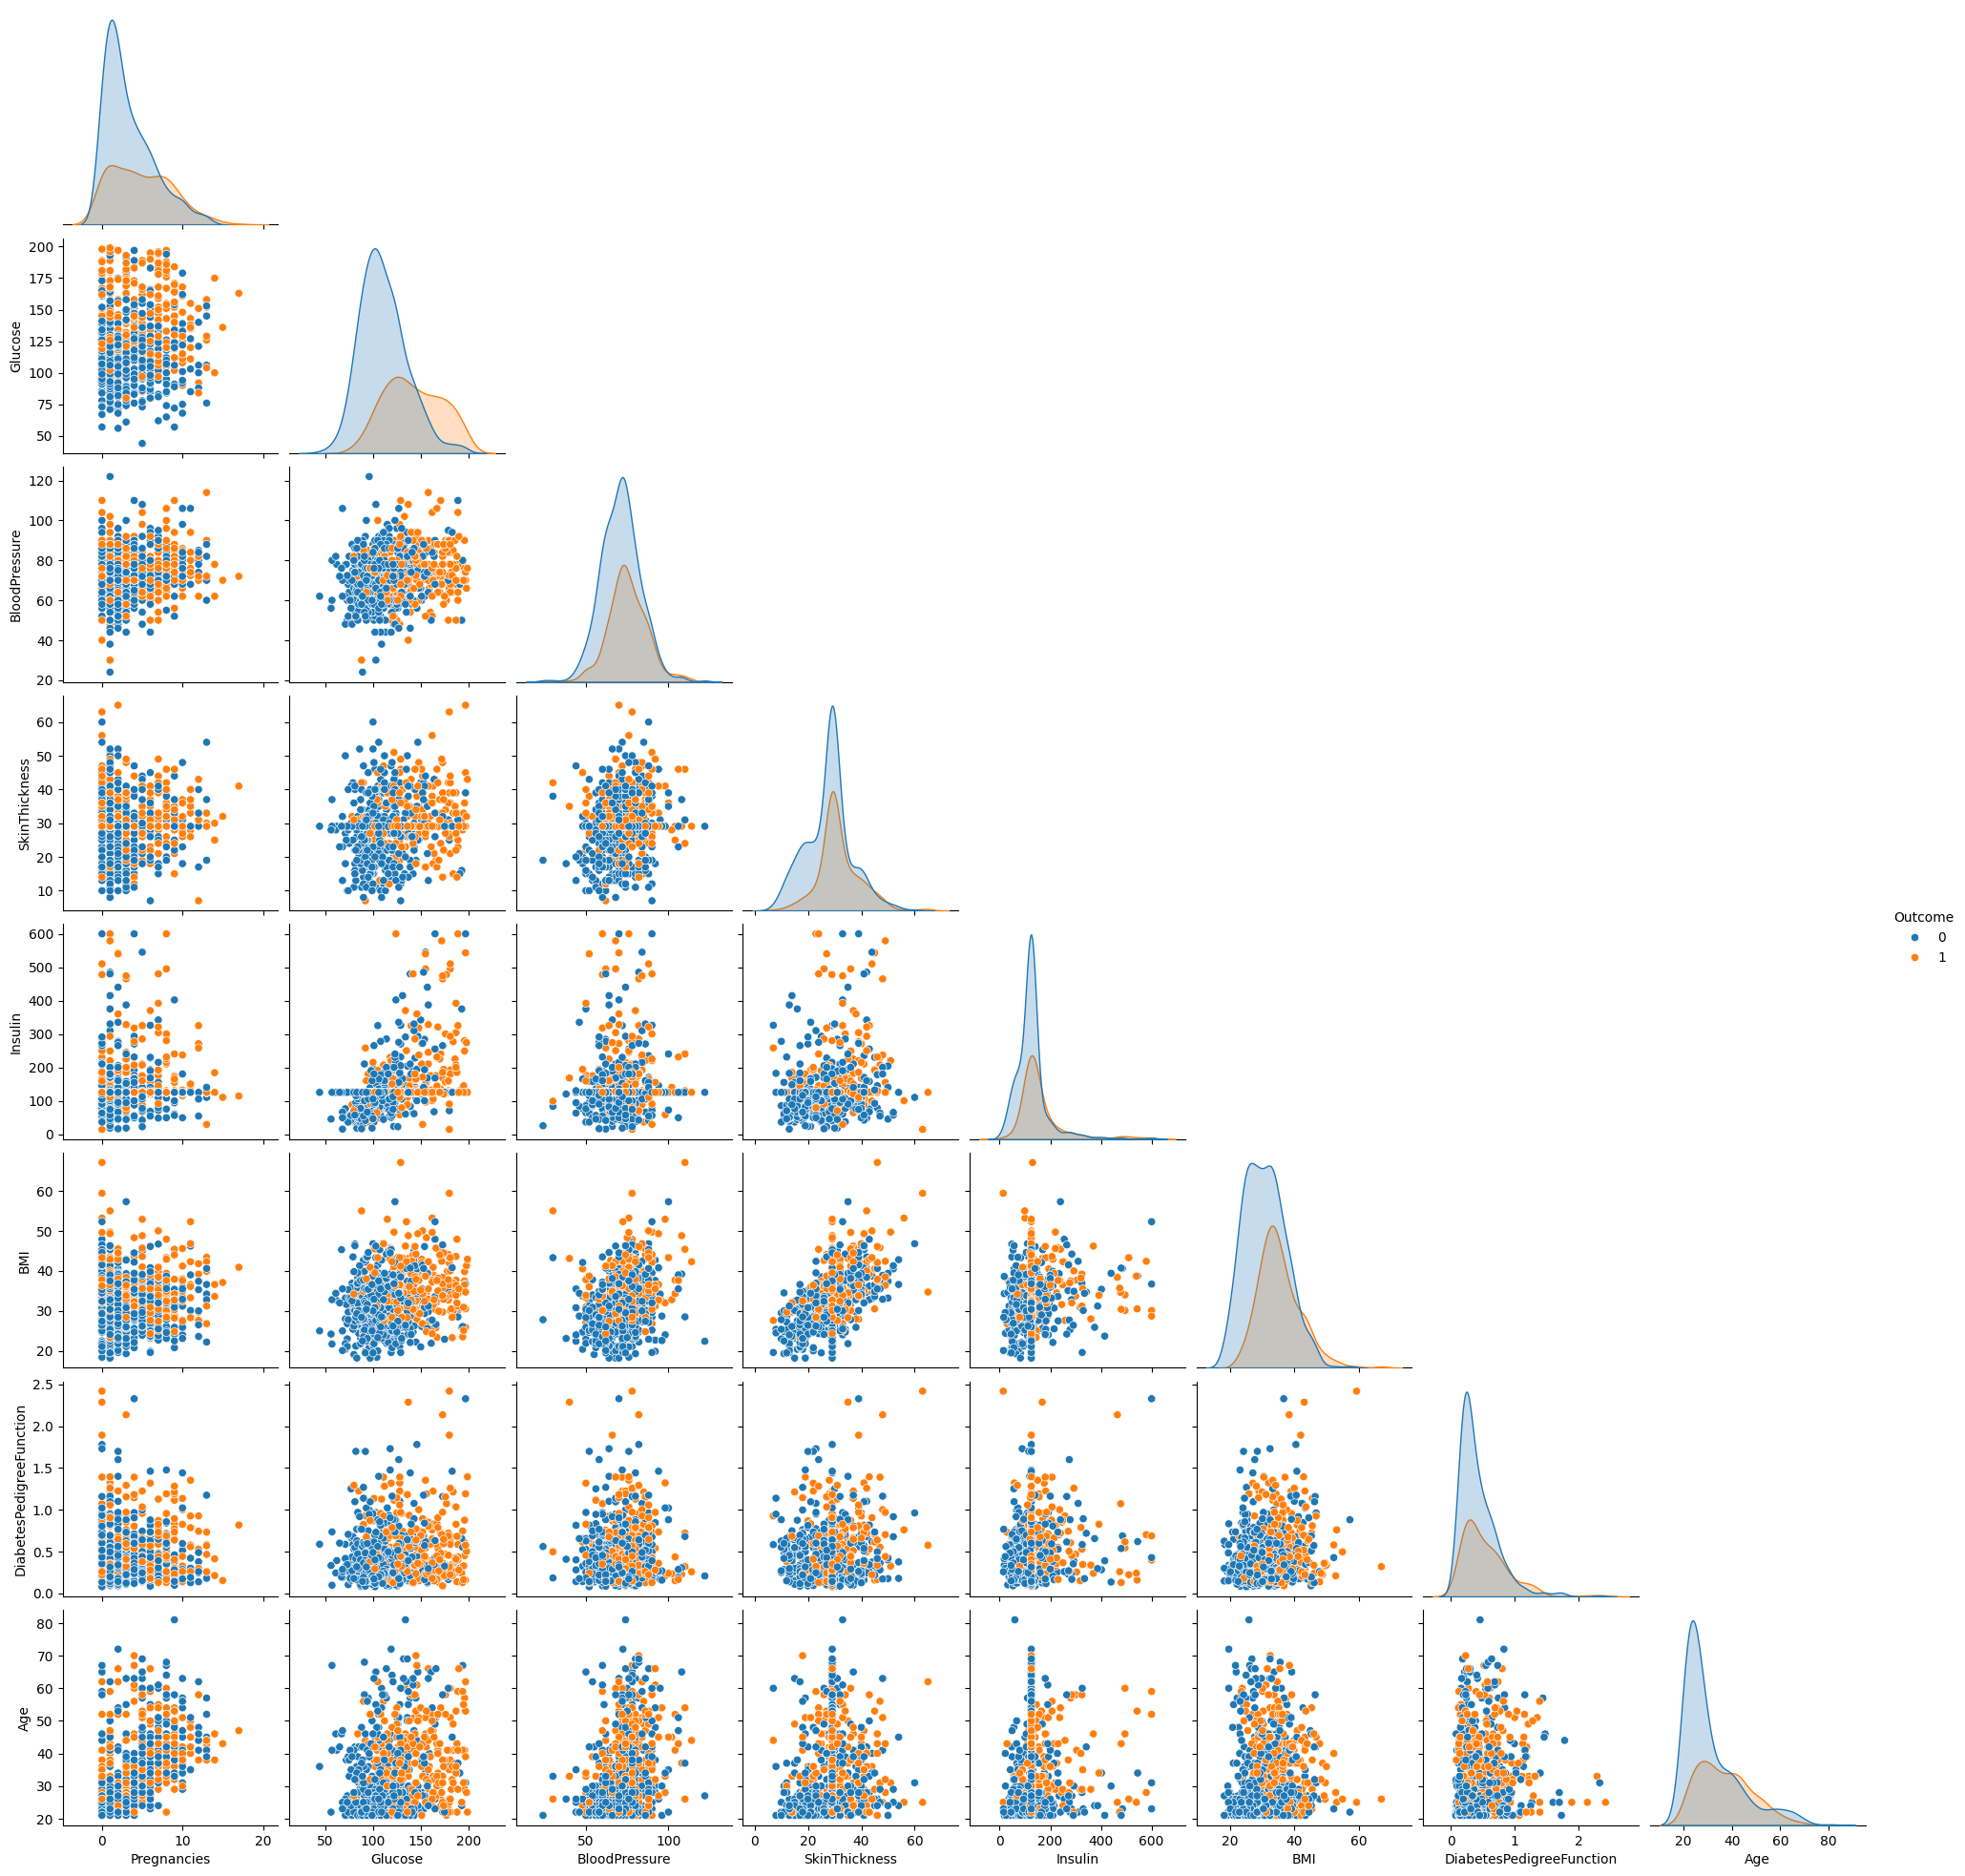

In [ ]:
# Pairwise plot (Seaborn) of features

pairplot(diabetes_df, hue='Outcome', diag_kind='kde', corner=True)

show()

A few features (Glucose, Insulin, BMI) are discernibly left-shifted for class 0 (No Diabetes) compared to class 1 (Diabetes).<br>
Classification might be possible...

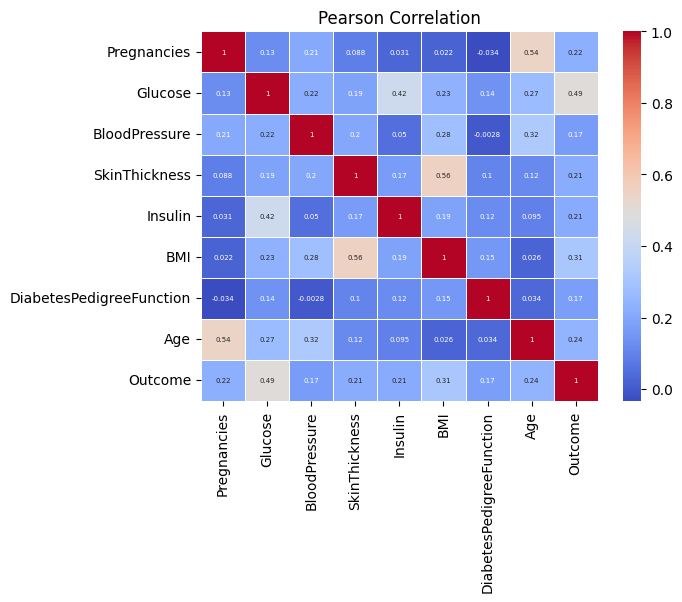

In [ ]:
# Pearson Correlation

pc_mat = diabetes_df.corr(method='pearson')

fig, ax = subplots()

heatmap(pc_mat, annot=True, annot_kws={'fontsize':5}, linewidths=0.5, cmap='coolwarm')
ax.set_title('Pearson Correlation')

show()

Apart from Glucose, there are no other features with strong linear correlations to Outcome.

# Define X & y datasets

In [28]:
X_df = diabetes_df.drop(columns='Outcome')  # Features
X = X_df.to_numpy()  # Convert Pandas df to NumPy array
print(X.shape)

y_df = diabetes_df['Outcome']  # Target labels
y = y_df.to_numpy()  # Convert Pandas df to NumPy array
print(y.shape)

(768, 8)
(768,)


# Split data

In [29]:
# Train Test Split

RS = 962

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RS)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


# Scale

In [30]:
# Scale

rob_scl = RobustScaler()  # Use Robust Scaler because of the high number of insulin outliers

X_train_scaled = rob_scl.fit_transform(X_train)
print(X_train_scaled)

X_test_scaled = rob_scl.transform(X_test)
print(X_test_scaled)

[[-0.2        -0.44186047 -0.88608458 ...  0.25414365 -0.44316731
  -0.47058824]
 [ 0.         -0.81395349 -0.17179887 ... -1.24861878  0.04469987
  -0.29411765]
 [ 1.6        -0.3255814  -0.31465601 ...  1.52486188 -0.62707535
   0.70588235]
 ...
 [-0.4        -0.02325581 -0.17179887 ... -0.55248619 -0.42784163
  -0.52941176]
 [-0.4        -0.88372093  0.18534399 ... -0.0441989   0.06257982
  -0.47058824]
 [-0.2        -0.58139535  0.25677256 ... -0.90607735  3.38825032
  -0.11764706]]
[[ 0.         -0.13953488 -1.02894173 ... -0.32044199  0.14942529
  -0.47058824]
 [ 0.2         0.6744186   0.3996297  ...  0.67403315  0.37931034
   2.17647059]
 [-0.6         1.44186047 -1.6003703  ...  0.59668508  0.21328225
  -0.47058824]
 ...
 [ 1.8         0.79069767 -0.17179887 ...  1.03867403  0.94636015
   0.47058824]
 [-0.2        -0.20930233  0.54248684 ... -0.59668508 -0.28735632
   1.29411765]
 [ 0.4        -0.02325581  0.11391542 ... -0.75138122 -0.43550447
   0.        ]]


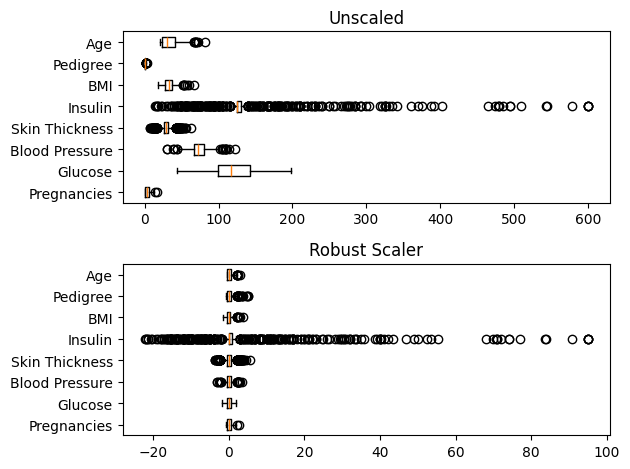

In [31]:
# Inspect scaling effect

n_rows = 2
n_cols = 1
y_labels = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Pedigree', 'Age']
fig, ax = subplots(nrows=n_rows, ncols=n_cols)

ax[0].boxplot(X_train, vert=False)
ax[0].set_yticklabels(y_labels)
ax[0].set_title('Unscaled')

ax[1].boxplot(X_train_scaled, vert=False)
ax[1].set_yticklabels(y_labels)
ax[1].set_title('Robust Scaler')

fig.tight_layout()

show()

# Artificial Neural Network

In [32]:
# Create ANN architecture
# Instantiate a sequential artificial neural network object
ann = Sequential()

# Input layer
ann.add(Input(shape=(8,)))  # Specify 8 features in our dataset

# Hidden layer1
ann.add(Dense(units=16, activation='relu'))  # 16 nodes

# Hidden layer2
ann.add(Dense(units=8, activation='relu'))  # 8 nodes

# Output layer
ann.add(Dense(units=1, activation='sigmoid'))  # 1 node for binary classification output 

# Compile & summarise
ann.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

ann.summary()

# Fit
model_history = ann.fit(x=X_train_scaled, y=y_train, batch_size=50, epochs=30, validation_split=0.2, verbose=2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
10/10 - 1s - 52ms/step - accuracy: 0.4094 - loss: 1.0441 - val_accuracy: 0.5447 - val_loss: 0.6974
Epoch 2/30
10/10 - 0s - 5ms/step - accuracy: 0.6680 - loss: 0.6724 - val_accuracy: 0.6992 - val_loss: 0.6619
Epoch 3/30
10/10 - 0s - 4ms/step - accuracy: 0.6619 - loss: 0.6674 - val_accuracy: 0.6911 - val_loss: 0.6492
Epoch 4/30
10/10 - 0s - 4ms/step - accuracy: 0.6823 - loss: 0.6508 - val_accuracy: 0.7317 - val_loss: 0.6294
Epoch 5/30
10/10 - 0s - 4ms/step - accuracy: 0.6884 - loss: 0.6381 - val_accuracy: 0.7480 - val_loss: 0.6123
Epoch 6/30
10/10 - 0s - 5ms/step - accuracy: 0.7149 - loss: 0.6202 - val_accuracy: 0.7724 - val_loss: 0.5866
Epoch 7/30
10/10 - 0s - 4ms/step - accuracy: 0.7230 - loss: 0.5915 - val_accuracy: 0.7561 - val_loss: 0.5424
Epoch 8/30
10/10 - 0s - 5ms/step - accuracy: 0.7413 - loss: 0.5606 - val_accuracy: 0.7398 - val_loss: 0.5111
Epoch 9/30
10/10 - 0s - 4ms/step - accuracy: 0.7434 - loss: 0.5454 - val_accuracy: 0.7642 - val_loss: 0.4945
Epoch 10/30
10/10 

In [ ]:
model_history.history
model_history.epoch

In [34]:
# Assemble history in a df

history_df = DataFrame(model_history.history)

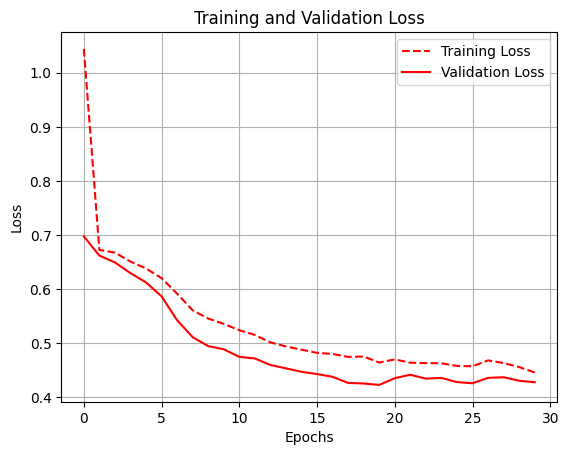

In [35]:
# Evaluate loss minimisation

fig, ax = subplots()

ax.plot(history_df.loc[:, ['loss']], c='r', linestyle='--', label='Training Loss')
ax.plot(history_df.loc[:, ['val_loss']],c='r', label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend(loc="best")

show()

Convergence of loss minimisation.

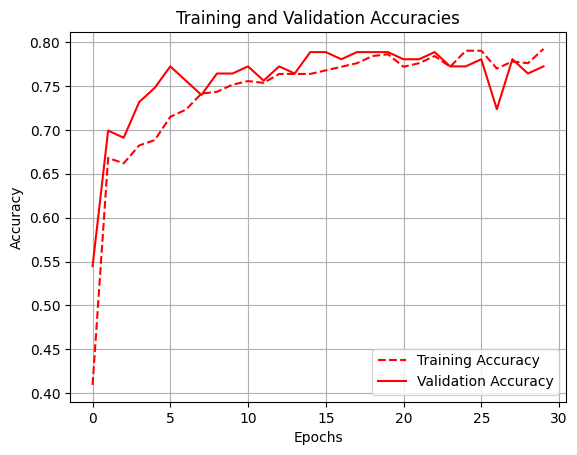

In [36]:
# Evaluate accuracy

fig, ax = subplots()

ax.plot(history_df.loc[:, ['accuracy']], c='r', linestyle='--', label='Training Accuracy')
ax.plot(history_df.loc[:, ['val_accuracy']],c='r', label='Validation Accuracy')
ax.set_title('Training and Validation Accuracies')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend(loc="best")

show()

Encouraging that there is convergence of the losses and accuracy scores!

In [37]:
# Predict with trained ANN

y_pred_ann = ann.predict(X_test_scaled)  # y_pred_ann returns an array of probabilities (0-1)
print(y_pred_ann.shape)
# print(y_pred_ann)

# Assign 1 if y_pred_ann >= 0.4, else 0
y_pred_ann = where(y_pred_ann >= 0.4, 1, 0)
print(y_pred_ann.shape)
# print(y_pred_ann)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(154, 1)
(154, 1)


In [38]:
# Plot Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, ax=None):
    """
    This function prints/plots the confusion matrix (adapted from a SciKit-Learn example)

    y_true: Actual class labels (array)
    y_pred: Predicted class labels (array)
    classes: Class names (str, array)
    normalize: Normalize the results (True), or show as integer values (False)
    ax: Visualization axis
    """

    from itertools import product
    from numpy import asarray, newaxis
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(classes)

    if normalize:
        cm = asarray(cm).astype('float32') /cm.sum(axis=1)[:, newaxis]

    if not ax:
        from matplotlib.pyplot import subplots, show
        fig, ax = subplots()

    ticks = range(n_classes)
    ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    fmt = '.2f' if normalize else 'd'
    thresh = 3*cm.max() / 4
    cm_dim = cm.shape

    # Matrix indices:
    indices_a = range(cm_dim[0])
    indices_b = range(cm_dim[1])
    # Cartesian product of matrix indices:
    indices = product(indices_a, indices_b)
    fmt = '.3f' if normalize else 'd'

    for ind_a, ind_b in indices:
      label = format(cm[ind_a, ind_b], fmt)
      color = "white" if cm[ind_a, ind_b] > thresh else "black"
      ax.text(ind_b, ind_a, label, ha="center", color=color)
    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')

    return ax

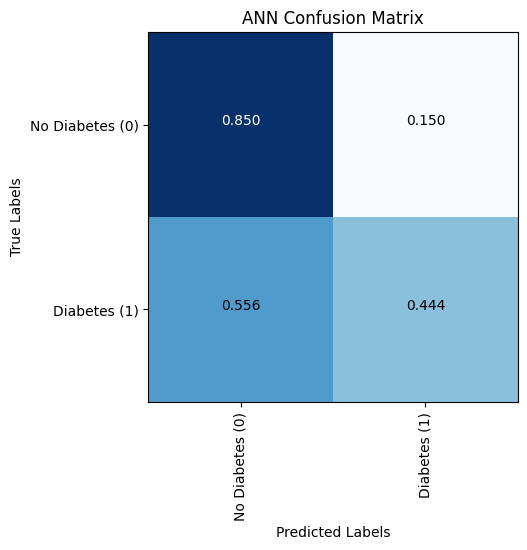

In [39]:
# Evaluate confusion matrix

class_names = ('No Diabetes (0)', 'Diabetes (1)')

fig, ax = subplots()
plot_confusion_matrix(y_test, y_pred_ann, classes=class_names, normalize=True, ax=ax)
ax.set_title('ANN Confusion Matrix', fontsize=12)

show()

False negative rate is about the same as chance.<br>
True positive rate is also similar to chance.

In [40]:
# Classification report

class_report = classification_report(y_test, y_pred_ann)
print(class_report)

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       100
           1       0.62      0.44      0.52        54

    accuracy                           0.71       154
   macro avg       0.68      0.65      0.65       154
weighted avg       0.70      0.71      0.69       154



Prediciting 0 (no diabetes) is more successful than predicting 1 (diabetes) - reflecting the unbalanced labels in the dataset.

# Supervised ML Modelling

In [41]:
# Explore 10 classifiers

RS = 962

classifiers = {'Random Forest': RandomForestClassifier(random_state=RS, n_jobs=-1),
               'AdaBoost (Random Forest)': AdaBoostClassifier(RandomForestClassifier(random_state=RS, n_jobs=-1)),
               'ExtRa Trees': ExtraTreesClassifier(random_state=RS, n_jobs=-1),
               'AdaBoost (Extra Tree)': AdaBoostClassifier(ExtraTreesClassifier(random_state=RS, n_jobs=-1)),
               'Decision Tree': DecisionTreeClassifier(criterion='gini', random_state=RS),
               'SVC (RBF)': SVC(random_state=RS),
               'SVC (Linear)': LinearSVC(random_state=RS),
               'Naive Bayes': GaussianNB(),
               'K-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
               'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RS, n_jobs=-1)}

In [42]:
# Cross Validation (Stratified Shuffle Split)

n_splits = 10
train_size = 0.8
sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=RS)

In [43]:
# Scale X data after splitting

scores_clf = []  # List for classifiers' scores; NB: some clfs, such as RandomForest, do not have accuracy_score, so use 'score' instead
recall_clf = []  # List for classifiers' recall scores
precision_clf = []  # List for classifiers' precision scores
for train_ind, test_ind in sss.split(X, y):  # .split() returns indices for the train and test sample splits
    X_train = X[train_ind, :]  # train_ind = indices of rows used for training
    X_train = rob_scl.fit_transform(X_train)  # Scale the training data

    X_test = X[test_ind, :]  # test_ind = indices of rows used for testing
    X_test = rob_scl.transform(X_test)  # Transform the test data with the fitted median and quartiles
    
    y_train = y[train_ind]
    y_test = y[test_ind]

    scores_splits = []  # List of split scores for each classifier
    recall_splits = []  # List of split recall scores for each classifier
    precision_splits = []  # List of split precision scores for each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        recall_splits.append(recall_score(y_test, y_pred, pos_label=0))  # Set the positive label = 0(malignant). Calculates the recall scores for each of the classifiers using the same X_test and y_test splits, and appends to list
        precision_splits.append(precision_score(y_test, y_pred))  # Calculates the precision scores for each of the classifiers using the same X_test and y_test splits, and appends to list
        scores_splits.append(clf.score(X_test, y_test))  # Calculates the scores for each of the classifiers using the same X_test and y_test splits, and appends to list

    recall_clf.append(recall_splits)  # Appends all classifiers' recall scores for the same X_test and y_test splits
    precision_clf.append(precision_splits)  # Appends all classifiers' precision scores for the same X_test and y_test splits
    scores_clf.append(scores_splits)  # Appends all classifiers' scores for the same X_test and y_test splits

recall_mean = round(mean(recall_clf, axis=0) * 100, 1)  # axis=0: calculate mean recall scores of columns/classifier
precision_mean = round(mean(precision_clf, axis=0) * 100, 1)  # axis=0: calculate mean precision scores of columns/classifier
scores_mean = round(mean(scores_clf, axis=0) * 100, 1)  # axis=0: calculate mean scores of columns/classifier


In [ ]:
# Sneak peek at model metrics

print(recall_mean)
print(precision_mean)
print(scores_mean)

[84.2 84.1 84.9 84.5 77.1 88.8 87.8 80.6 80.2 87.4]
[66.5 66.5 67.6 66.7 57.2 66.4 71.  62.8 58.9 70.7]
[74.5 74.6 75.3 74.6 70.1 71.  76.2 73.4 70.5 76.3]


Mmm, so-so.

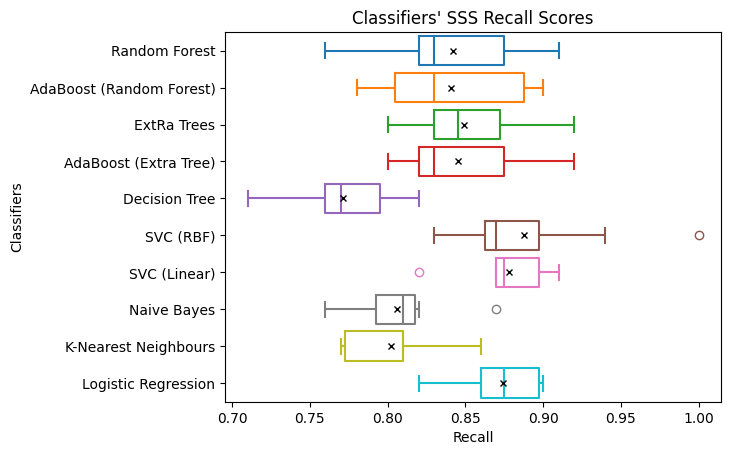

In [45]:
# Boxplot (Seaborne) of classifiers' recall scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
recall_clf_df = DataFrame(recall_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=recall_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Recall Scores")
ax.set_xlabel('Recall')
ax.set_ylabel('Classifiers')

show()

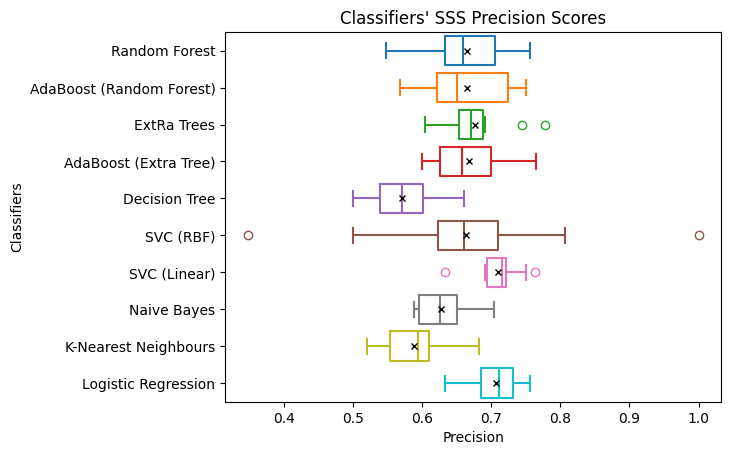

In [46]:
# Boxplot (Seaborne) of classifiers' precision scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
precision_clf_df = DataFrame(precision_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=precision_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Precision Scores")
ax.set_xlabel('Precision')
ax.set_ylabel('Classifiers')

show()

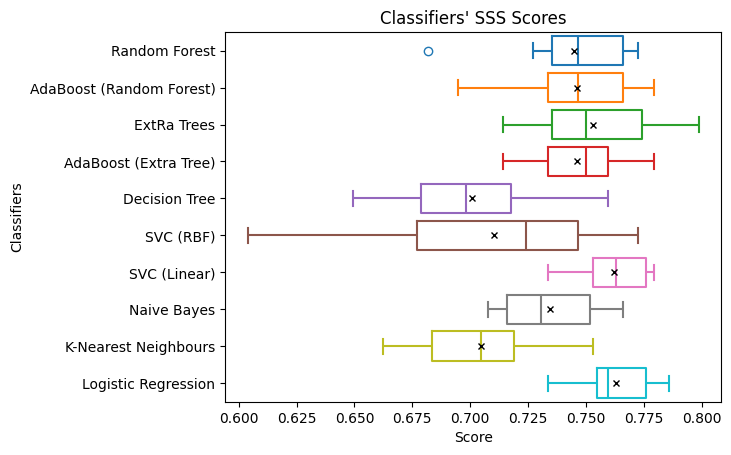

In [47]:
# Boxplot (Seaborne) of classifiers' scores resulting from Stratified Shuffle Split

# Convert list to Pandas Dataframe for Seaborne
scores_clf_df = DataFrame(scores_clf, columns=[name for name in classifiers.keys()])

fig, ax = subplots()

boxplot(data=scores_clf_df, orient='h', fill=False, showmeans=True, meanprops={'marker':'x',
                                                                                'markeredgecolor':'k',
                                                                                'markersize':'5'})
ax.set_title("Classifiers' SSS Scores")
ax.set_xlabel('Score')
ax.set_ylabel('Classifiers')

show()

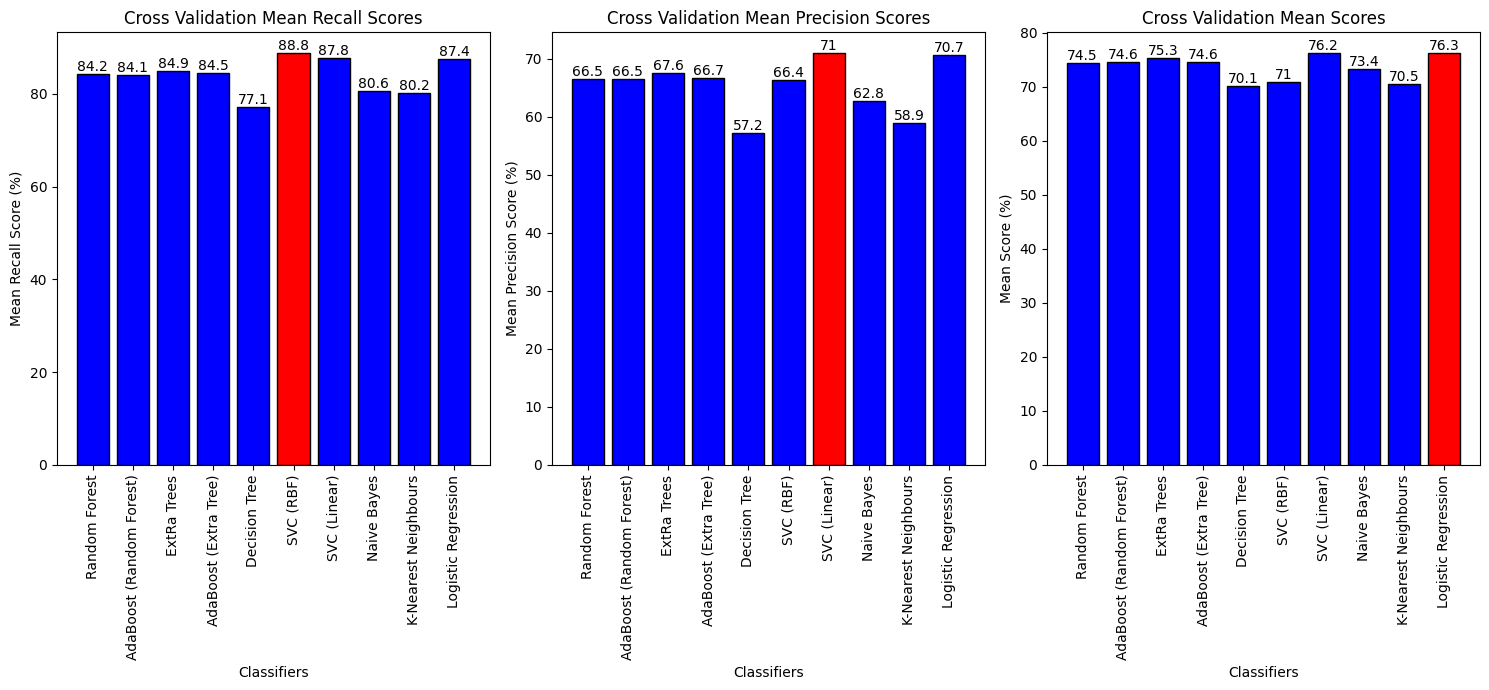

In [48]:
# PLot classifiers' mean scores resulting from Stratified Shuffle Split

plt_labels = list(classifiers.keys())  # Create a list of classifier names from the dictionary keys to be used as plot labels
xticks = arange(len(classifiers.keys()))  # Specify the number of x-ticks

recall_colour = ['r' if (bar == max(recall_mean)) else 'b' for bar in recall_mean]  # Colour the highest mean recall score red
precision_colour = ['r' if (bar == max(precision_mean)) else 'b' for bar in precision_mean]  # Colour the highest mean precision score red
score_colour = ['r' if (bar == max(scores_mean)) else 'b' for bar in scores_mean]  # Colour the highest mean score red

fig, ax = subplots(ncols=3, figsize=(15, 7))

recall_bar_con = ax[0].bar(x=xticks, height=recall_mean, tick_label=plt_labels, color=recall_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[0].bar_label(recall_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[0].set_ylabel('Mean Recall Score (%)')
ax[0].set_xlabel('Classifiers')
ax[0].set_xticklabels(plt_labels, rotation=90)
ax[0].set_title("Cross Validation Mean Recall Scores");

precision_bar_con = ax[1].bar(x=xticks, height=precision_mean, tick_label=plt_labels, color=precision_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[1].bar_label(precision_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[1].set_ylabel('Mean Precision Score (%)')
ax[1].set_xlabel('Classifiers')
ax[1].set_xticklabels(plt_labels, rotation=90)
ax[1].set_title("Cross Validation Mean Precision Scores");

score_bar_con = ax[2].bar(x=xticks, height=scores_mean, tick_label=plt_labels, color=score_colour, edgecolor='k')  # Create a bar container to label the bars with the scores
ax[2].bar_label(score_bar_con)  # .bar_label() uses the the data values (i.e., height=) from the container (bar_con) as labels
ax[2].set_ylabel('Mean Score (%)')
ax[2].set_xlabel('Classifiers')
ax[2].set_xticklabels(plt_labels, rotation=90)
ax[2].set_title("Cross Validation Mean Scores")

fig.tight_layout()

show()

Most classifiers perform generally well with almost all metrics. The notable exception being Decision Tree.<br>The recall score is particularly important for the diabetes diagnosis to maximise the true positive rate (while minimising false negatives),<br>while the precision score reflects minimising false positives.

In [49]:
# Split training and test data and scale X data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=RS, shuffle=True)
X_train_scaled = rob_scl.fit_transform(X_train)
X_test_scaled = rob_scl.transform(X_test)

print(X.shape, X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(768, 8) (614, 8) (154, 8) (614,) (154,)


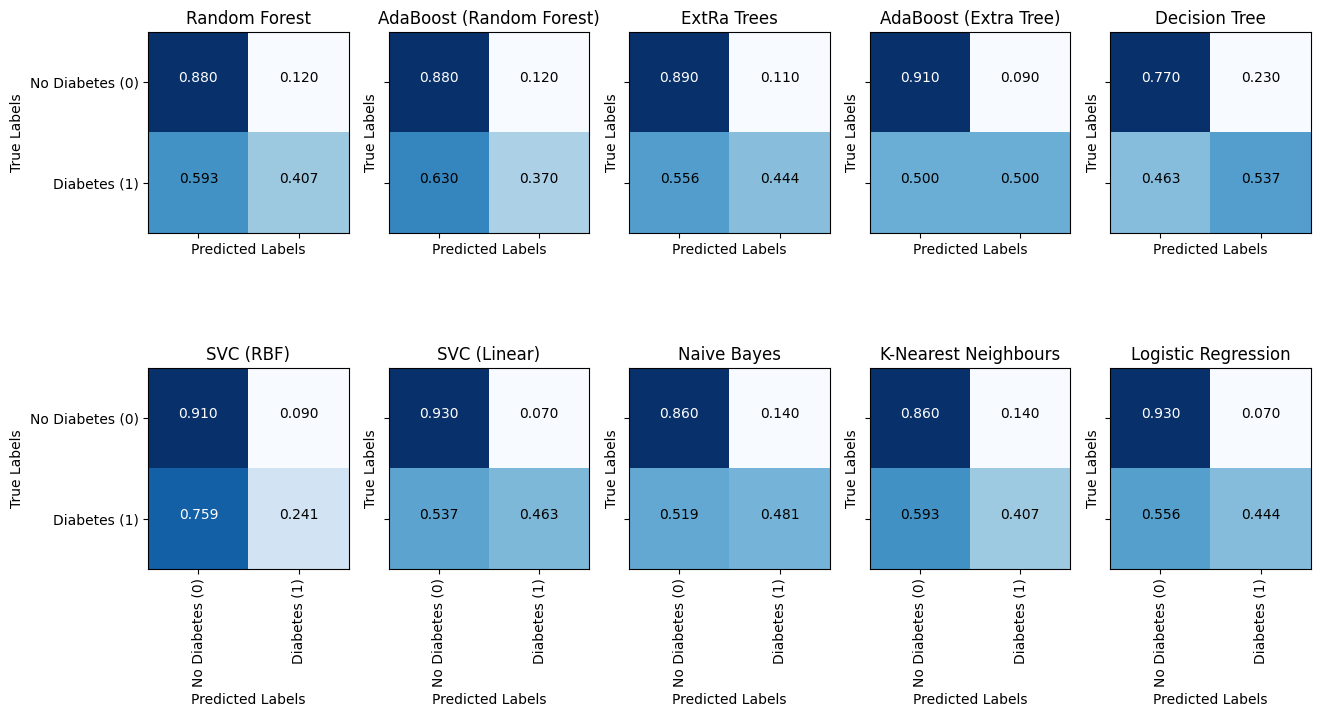

In [50]:
# Confusion matrix evaluation
class_names = ('No Diabetes (0)', 'Diabetes (1)')

fig, axes = subplots(figsize=(15, 8), ncols=5, nrows=2, sharey=True, sharex=True)

for ax, (name, clf) in zip(axes.ravel(), classifiers.items()):
    clf.fit(X_train_scaled, y_train)  # Fit with training data
    y_pred = clf.predict(X_test_scaled)  # Predict class labels using test data

    plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, ax=ax)
    ax.set_title(name, fontsize=12)

show()

Most of the classifiers have high true negative (TN > 80%) <i>i.e.</i>, identified high percentage of no diabetes correctly.<br><br>
All classifiers scored poorly for true positives (TP < 50%) <i>i.e.</i>, failed to identified diabetes correctly.<br><br>Since this dataset is concerned with correct diagnosis, having low false negatives is important - all models performed poorly.

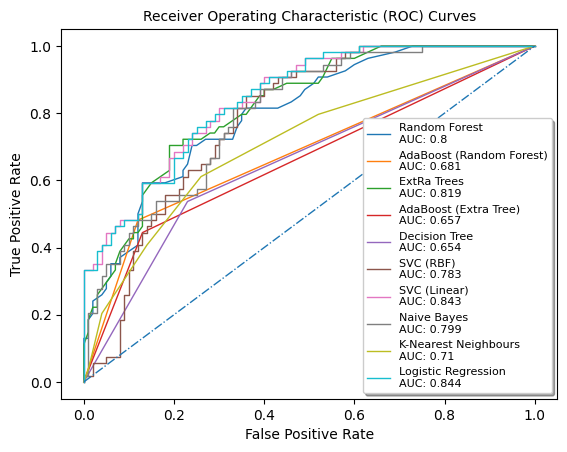

In [51]:
# ROC AUC evaluation
# A more comprehensive picture of TPR v FPR (considering all thresholds of Confusion Matrix)

fig, ax = subplots()

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)

    # Checking whether or not the object has 'decision_function':
    if hasattr(clf, 'decision_function'):  # If it does...
        y_score = clf.decision_function(X_test_scaled)
    else:
        y_score = clf.predict_proba(X_test_scaled)[:, 1]  # We only need probabilities for one column.

    # Obtaining the x- and y-axis values for the ROC curve:
    fpr, tpr, thresh = roc_curve(y_test, y_score)

    # Obtaining the AUC value:
    roc_auc = roc_auc_score(y_test, y_score)

    ax.plot(fpr, tpr, lw=1, label = f'{name}\nAUC: {round(roc_auc, 3)}')

ax.plot([0, 1], [0, 1], lw=1, linestyle='-.') 
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=10)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(ncols=1, fontsize=8, shadow=True)

show()

The ROC-AUC are generally poor: logistic regression and SVC(linear) outperforming the others.<br>
All things considered, will take logistic regression model forward.

# Predict diabetes using logistic regression model on 'new' data<br>
From the explorartory data analysis, I noticed that the means of some of the no diabetes features are generally lower than the means of the same diabetes features

In [ ]:
# From the explorartory data analysis, I noticed that the means of some of the no diabetes features are generally lower than the means of the same diabetes features

# Create 'new patient' data from the means of the features of the classes
new_data = diabetes_df.groupby('Outcome').mean().to_numpy()
# print(new_data, new_data.shape)

nodia_means = new_data[0, :].reshape(1, 8)  # Test no-diabetes dataset based on means
# print(nodia_means, nodia_means.shape)

dia_means = new_data[1, :].reshape(1, 8)  # Test diabetes dataset based on means
# print(dia_means, dia_means.shape)


                No Diabetes    Diabetes
Pregnancies        3.298000    4.865672
Glucose          110.710121  142.165573
Blood Pressure    70.935397   75.147324
Skin Thickness    27.751179   31.589442
Insulin          127.344000  163.783582
BMI               30.888434   35.384757
Pedigree           0.429734    0.550500
Age               31.190000   37.067164


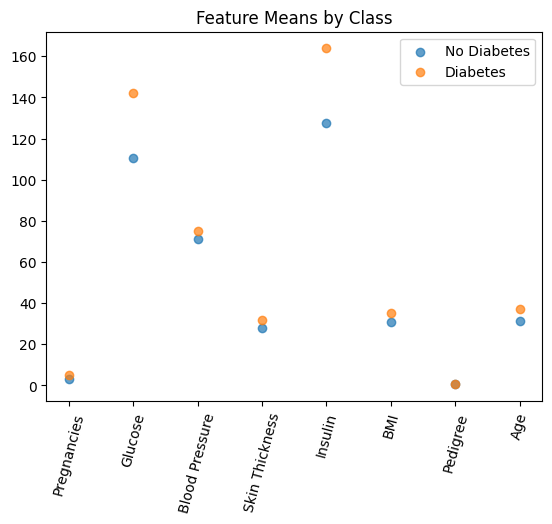

In [53]:
# Inspect means-based test datasets

x_labels = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Pedigree', 'Age']
mean_df = DataFrame({'No Diabetes': nodia_means.ravel(), 'Diabetes': dia_means.ravel()}, index=x_labels)

print(mean_df)

labels = ['No Diabetes', 'Diabetes']
fig, ax = subplots()

ax.scatter(arange(0,8,1), nodia_means.reshape(-1,1), alpha=0.7)
ax.scatter(arange(0,8,1), dia_means.reshape(-1,1), alpha=0.7)
ax.set_xticks(arange(0,8,1), labels=x_labels, rotation=75)
ax.legend(labels=labels)
ax.set_title('Feature Means by Class')

show()

In [54]:
# Train logistic regression model and predict using newly created means-based test datasets

log_reg = LogisticRegression(max_iter=500, random_state=RS, n_jobs=-1)
# print(X.shape, y.shape)
log_reg.fit(X, y)  # Train on entire dataset

def diagnose(data):
    y_pred = log_reg.predict(data)
    prob = log_reg.predict_proba(data)
    # print(y_pred1)
    # print(prob1)
    if y_pred == 0:
        print(f"No diabetes (0) (probability {prob[0][0]})")
    else:
        print(f"Diabetes (1) (probability {prob[0][1]})")


# Predict diagnosis of 'new patient' using test no diabetes data
diagnose(nodia_means)

# Predict diagnosis of 'new patient' using test diabetes data
diagnose(dia_means)


No diabetes (0) (probability 0.8216911645361439)
Diabetes (1) (probability 0.5948282348153072)


The logistic regression model predicted correctly(!), but with lower probability for class 1 than for class 0.